# I) Administratif

## Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [95]:
victor = False
tomas = True
if tomas:
  path_to_your_folder =  "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if victor:
  path_to_your_folder = "/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv"
%cd $path_to_your_folder



/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv


## Libraries

In [96]:
import sys
sys.path.append("./utils")
sys.path.append("./helpers")


In [97]:
from IPython.display import clear_output


In [98]:

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [99]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from save_training_results import save_results
from mask_to_submission import masks_to_submission
from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset

## For custom
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from typing import Optional, List
import torch.nn as nn
import segmentation_models_pytorch.utils.base as base
import segmentation_models_pytorch.utils.functional as F
from segmentation_models_pytorch.base.modules import Activation

## For submission
from torchvision.transforms.functional import to_pil_image, to_tensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# II) Model definition

## Command board

In [100]:
PARAMS = {
  'MODELS' : ["Unet","DeepLabV3","FPN", "UnetPlusPlus"], # Available : "Unet","DeepLabV3","FPN", "UnetPlusPlus"
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 30,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : False, #choose whether the data is augmented to 900 images or use original dataset of 100 images,
  'CLASSES' : ['road'],
}

In [101]:
# Default parameters for various parts
foreground_threshold = 0.5  # Threshold for determining foreground vs background

loss_type = "dice" # Possible: ["dice", "tversky", "custom"]
metric_type = "fscore" # Possible: ["custom", "fscore"]

#For custom, changes balance between pixel and patch
w_pix = 0
w_patch = 1



In [102]:
#Creates the necessary folders for saving results
model_weights_folder = './submissions/models/'
os.makedirs(model_weights_folder, exist_ok=True)


submission_folder = './submissions/'
os.makedirs(submission_folder, exist_ok=True)

## II.a) Dataset class

In [103]:
class Dataset(BaseDataset):
  CLASSES = ['road', 'unlabelled']

  def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None, plot = False):
      if masks_dir == None:
        self.ids = range(1, 51)
        self.images_fps = [os.path.join(images_dir, f'test_{idx}/',f'test_{idx}.png') for idx in self.ids]
      else:
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
      self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

      # convert str names to class values on masks
      if classes is not None:
          self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

      self.augmentation = augmentation
      self.preprocessing = preprocessing
      # self.preprocessing = None
      self.plot = plot

  def __getitem__(self, i):

      # read data
      image = cv2.imread(self.images_fps[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (416, 416))
      # initialize mask as None
      mask = None

      if self.masks_fps == None:
        if self.augmentation:
          sample = self.augmentation(image=image)
          image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        return self.images_fps[i], image

      else:
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.resize(mask, (416, 416))
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
              sample = self.preprocessing(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
        return image, mask

  def __len__(self):
      return len(self.ids)

## II.b) Preprocessing

### Data aug

In [104]:
# # @title
# # Create folders for data augmentation
#   %mkdir data/data_train_augmented
#   %mkdir data/data_train_augmented/images/
#   %mkdir data/data_train_augmented/masks/
#   %mkdir data/data_train_augmented/raw/
#   %mkdir data/data_train_augmented/raw/images/
#   %mkdir data/data_train_augmented/raw/masks/
#   %mkdir data/data_validation
#   %mkdir data/data_validation/images/
#   %mkdir data/data_validation/masks/
#   %mkdir data/data_validation/raw/
#   %mkdir data/data_validation/raw/images/
#   %mkdir data/data_validation/raw/masks/

#   # Load images and masks from dataset
#   PATH_IMG_TRAIN = "./data/training/images/"
#   PATH_MASK_TRAIN = "./data/training/groundtruth/"
#   img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
#   key_list = list(img_train.keys())
#   key_list.sort()

#   # Split the images for training/validation (+ store)
#   training_ratio = 0.8
#   seed = 1
#   train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

#   PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
#   PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
#   PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
#   PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

#   store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
#   store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
#   store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
#   store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

#   MASK_THRESHOLD = 120
#   SIZE_X = 416 #divisible by 32
#   SIZE_Y = 416 #divisible by 32
#   PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
#   PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
#   PATH_VAL_IMG = "./data/data_validation/images/"
#   PATH_VAL_MASK = "./data/data_validation/masks/"

#   # Load validation images and resize
#   img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
#   keys_val = list(img_val_raw.keys())
#   resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

#   # Load training images, resize and augment using geometric transformation (+ store)
#   img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
#   keys_tr = list(img_tr_raw.keys())
#   resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

### Normalization

In [105]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

## II.c) Dataset importation

In [106]:
## Importing pre processing
preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

In [107]:
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"


#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)



## II.d) Loss and evaluation metrics

### Patch based Loss and evaluation metrics


In [108]:
# Define the image crop function
def img_crop(im, h, w):
    list_patches = []
    imgwidth = im.shape[2]
    imgheight = im.shape[3]
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im_patch = im[:, :, j:j+w, i:i+h]
            list_patches.append((im_patch, i, j))
    return list_patches

# Define the value to class conversion function
def value_to_class(v, threshold):
    v_mean = v.mean(dim=(2, 3))
    return (v_mean > threshold).float()

def normalize_tensor(tensor):
    N, _, _, _ = tensor.shape
    normalized_tensor = torch.zeros_like(tensor)
    for i in range(N):
        min_val = tensor[i].min()
        max_val = tensor[i].max()
        normalized_tensor[i] = (tensor[i] - min_val) / (max_val - min_val)
    return normalized_tensor

# Assuming predictions_tensor and ground_truths_tensor are the input 4D tensors
def patch_extraction(predictions_tensor, ground_truths_tensor, threshold_pred=0.25, threshold_gt=0.25, print = False, norm = True):
    # # Resize dimensions
    # TARGET_SIZE = 608
    # predictions_tensor = F.interpolate(predictions_tensor, size=(TARGET_SIZE, TARGET_SIZE), mode='bilinear', align_corners=False)
    # ground_truths_tensor = F.interpolate(ground_truths_tensor, size=(TARGET_SIZE, TARGET_SIZE), mode='bilinear', align_corners=False)

    PATCH_SIZE = 16
    N, C, H, W = predictions_tensor.shape
    num_patches_height = H // PATCH_SIZE
    num_patches_width = W // PATCH_SIZE

    # Initialize tensors to hold the mean values
    predictions_means = torch.zeros((N, C, num_patches_height, num_patches_width))
    ground_truths_means = torch.zeros((N, C, num_patches_height, num_patches_width))

    # Crop the images into patches and compute the mean values
    predictions_patches = img_crop(predictions_tensor, PATCH_SIZE, PATCH_SIZE)
    ground_truths_patches = img_crop(ground_truths_tensor, PATCH_SIZE, PATCH_SIZE)

    # Assign the mean values to the correct location in the tensors
    for patch, i, j in predictions_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        predictions_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    for patch, i, j in ground_truths_patches:
        patch_idx_height = i // PATCH_SIZE
        patch_idx_width = j // PATCH_SIZE
        ground_truths_means[:, :, patch_idx_height, patch_idx_width] = patch.mean(dim=(2, 3))

    # Normalize ground truth means between 0 and 1
    if norm:
        predictions_means = normalize_tensor(predictions_means)

    # Apply threshold to determine class membership
    predictions_classes = (predictions_means > threshold_pred).float()
    ground_truths_classes = (ground_truths_means > threshold_gt).float()

    # Plot the mean images
    if print:
      fig, ax = plt.subplots(2, 2, figsize=(10, 5))
      ax[0, 0].imshow(predictions_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 0].set_title('Predictions Mean Patch')
      ax[0, 1].imshow(ground_truths_means[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[0, 1].set_title('Ground Truths Mean Patch')
      ax[1, 0].imshow(predictions_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 0].set_title('predictions_classes')
      ax[1, 1].imshow(ground_truths_classes[0].squeeze().detach().numpy(), cmap='gray')  # Detach and convert to numpy
      ax[1, 1].set_title('ground_truths_classes')
      plt.show()

      # Plot histograms
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.hist(predictions_means[0].squeeze().detach().numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Prediction Means')
      plt.title('Histogram of Prediction Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.hist(ground_truths_means[0].squeeze().detach().numpy().flatten(), bins=50, color='green', alpha=0.7, label='Ground Truth Means')
      plt.title('Histogram of Ground Truth Means')
      plt.xlabel('Pixel Values')
      plt.ylabel('Frequency')
      plt.legend()

      plt.tight_layout()
      plt.show()

    return predictions_classes, ground_truths_classes

In [109]:
## Composite metrics

class Custom_Fscore(base.Metric):
    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, w_pix = 1, w_patch = 1, **kwargs):
        super(Custom_Fscore,self).__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels
        self.w_pix = w_pix
        self.w_patch = w_patch
        print("Fscore w_pix: ", w_pix)
        print("Fscore w_patch: ", w_patch)

    def forward(self, pr, gt):
        pr = self.activation(pr)
        pr_pix = pr
        gt_pix = gt
        pr_patch, gt_patch = patch_extraction(pr, gt)

        f_score_pix = smp_utils.metrics.Fscore(
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        ).forward(pr_pix, gt_pix)

        f_score_patch = smp_utils.metrics.Fscore(
            beta=self.beta,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        ).forward(pr_patch, gt_patch)

        return (self.w_pix * f_score_pix + self.w_patch * f_score_patch) / (self.w_pix + self.w_patch)

### Final model choice

In [110]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp_utils.losses.DiceLoss()
# metrics = [
#     smp_utils.metrics.IoU(threshold=0.5),
#     smp_utils.metrics.Fscore(),
# ]
#myinstance.__class__.__name__

# loss_fn = CustomDiceLoss(w_pix = w_pix, w_patch = w_patch)
# loss_fn.__name__ = 'Custom_dice_loss'

# metrics = [
#       Custom_Fscore(w_pix = w_pix, w_patch = w_patch), ]

if loss_type == "dice":
  loss_fn = smp.losses.dice.DiceLoss(mode ='binary')
  loss_fn.__name__ = 'Dice_loss'
  loss_name = 'Dice_loss'
elif loss_type == "tversky":
  loss_fn = smp.losses.tversky.TverskyLoss(mode ='binary')
  loss_fn.__name__ = 'Tversky_Loss'
  loss_name = 'Tversky_Loss'
elif loss_type == "custom":
  print("Not implemented yet")

if metric_type == "custom":
  metrics = [
        Custom_Fscore(w_pix = w_pix, w_patch = w_patch), ]
  metric_name = "custom__fscore"
elif metric_type == "fscore":
  metrics = [
        smp_utils.metrics.Fscore(), ]
  metric_name = "fscore"

# III) Training

In [111]:
models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

Unet

Epoch: 0
valid: 100%|██████████| 16/16 [00:01<00:00,  8.48it/s, Dice_loss - 0.4325, fscore - 0.2645]
{'Dice_loss': 0.4325347132980824, 'fscore': 0.26452657114714384}
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:02<00:00,  7.43it/s, Dice_loss - 0.3251, fscore - 0.6498]
{'Dice_loss': 0.3250975087285042, 'fscore': 0.6497952323406935}
Model saved!

Epoch: 2
valid: 100%|██████████| 16/16 [00:00<00:00, 23.80it/s, Dice_loss - 0.2469, fscore - 0.8001]
{'Dice_loss': 0.246893472969532, 'fscore': 0.8000935968011619}
Model saved!

Epoch: 3
valid: 100%|██████████| 16/16 [00:00<00:00, 23.42it/s, Dice_loss - 0.2078, fscore - 0.8564]
{'Dice_loss': 0.2077994979918003, 'fscore': 0.8564114794135094}
Model saved!

Epoch: 4
valid: 100%|██████████| 16/16 [00:00<00:00, 22.36it/s, Dice_loss - 0.1927, fscore - 0.8746]
{'Dice_loss': 0.1926674507558346, 'fscore': 0.8746456541121007}
Model saved!

Epoch: 5
valid: 100%|██████████| 16/16 [00:00<00:00, 22.56it/s, Dice_loss - 0.1746, fscore - 0.8951

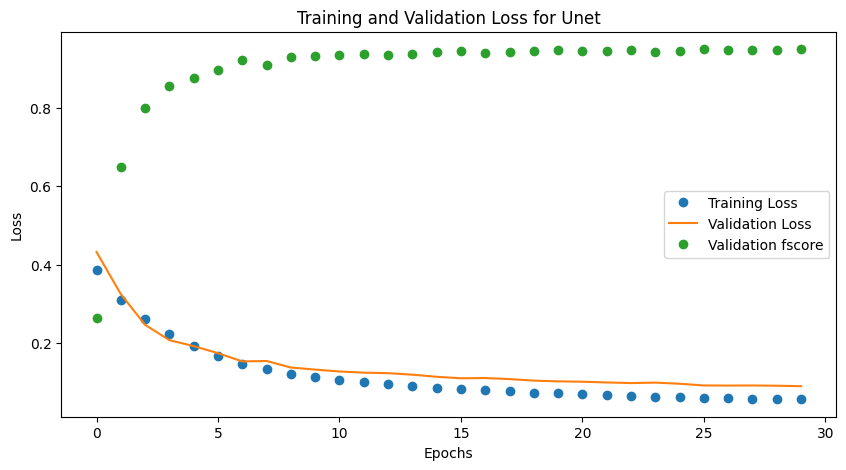

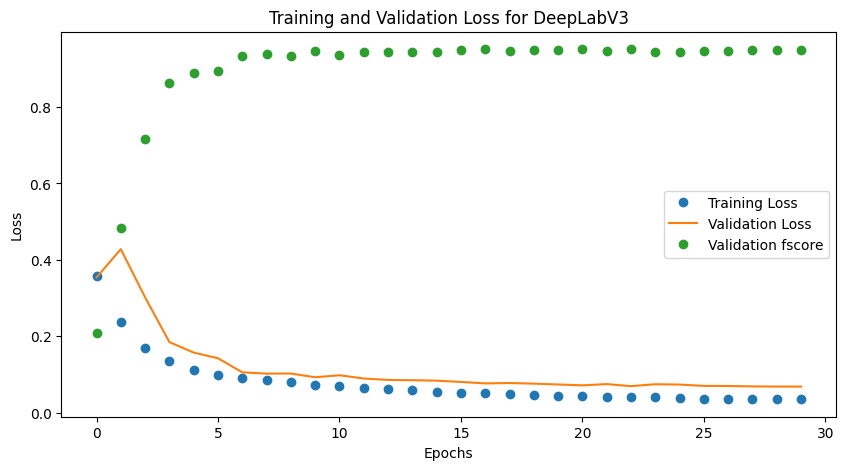

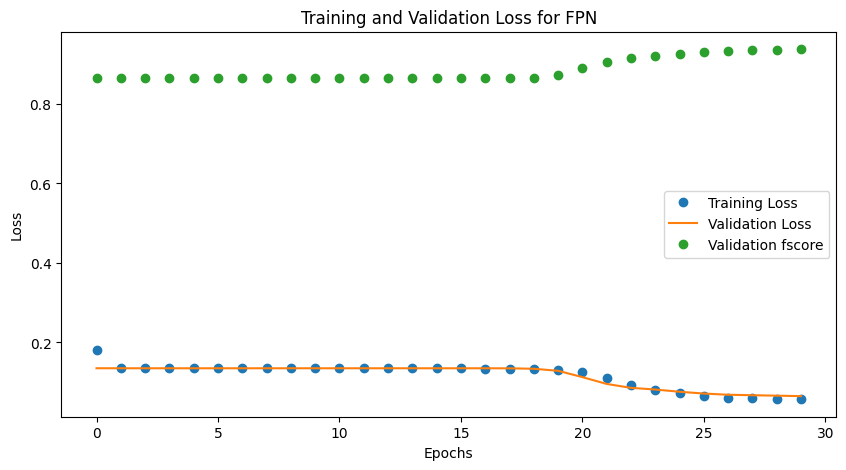

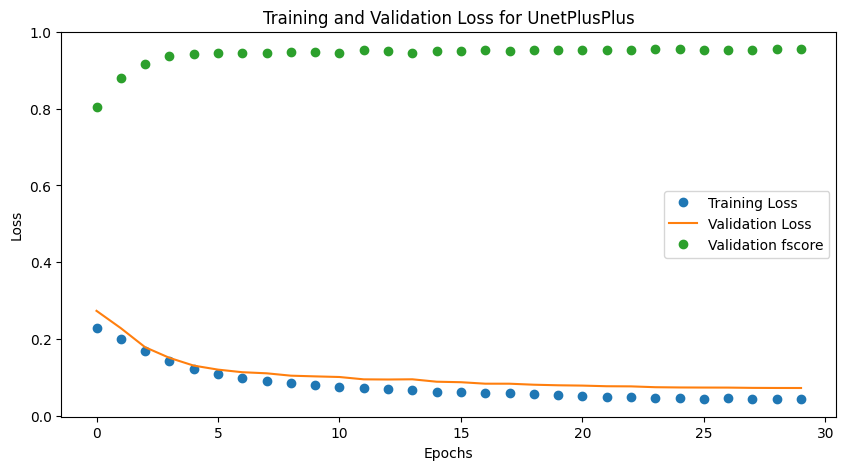

In [112]:
# train model for NB_EPOCHS
for model,model_name in models:
  print(model_name)
  lr = 1e-4
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=lr),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      optimizer=optimizer,
      device="cuda",
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss_fn,
      metrics=metrics,
      device="cuda",
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []



  for i in range(0, PARAMS["NB_EPOCHS"]):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)

      train_loss_array.append(train_logs[loss_name])
      validation_loss_array.append(valid_logs[loss_name])
      validation_fscore_array.append(valid_logs[metric_name])
      print(valid_logs)
      # do something (save model, change lr, etc.)
      if max_score < valid_logs[metric_name]:
          max_score = valid_logs[metric_name]
          torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))
          print('Model saved!')
      if i == 25:
          lr = lr/10
          optimizer.param_groups[0]['lr'] = lr
          print('Decrease decoder learning rate to {}'.format(lr))

  #     if i%10 == 0 and i !=0:
  #         lr = lr/10
  #         optimizer.param_groups[0]['lr'] = lr
  #         print('Decrease decoder learning rate to {}'.format(lr))



  epochs = range(0,len(train_loss_array))
  save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)


  plt.figure(figsize=(10, 5))
  plt.plot(epochs, train_loss_array,"o", label='Training Loss')
  plt.plot(epochs, validation_loss_array,  label='Validation Loss')
  plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
  plt.title('Training and Validation Loss for {}'.format(model_name))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()





/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv


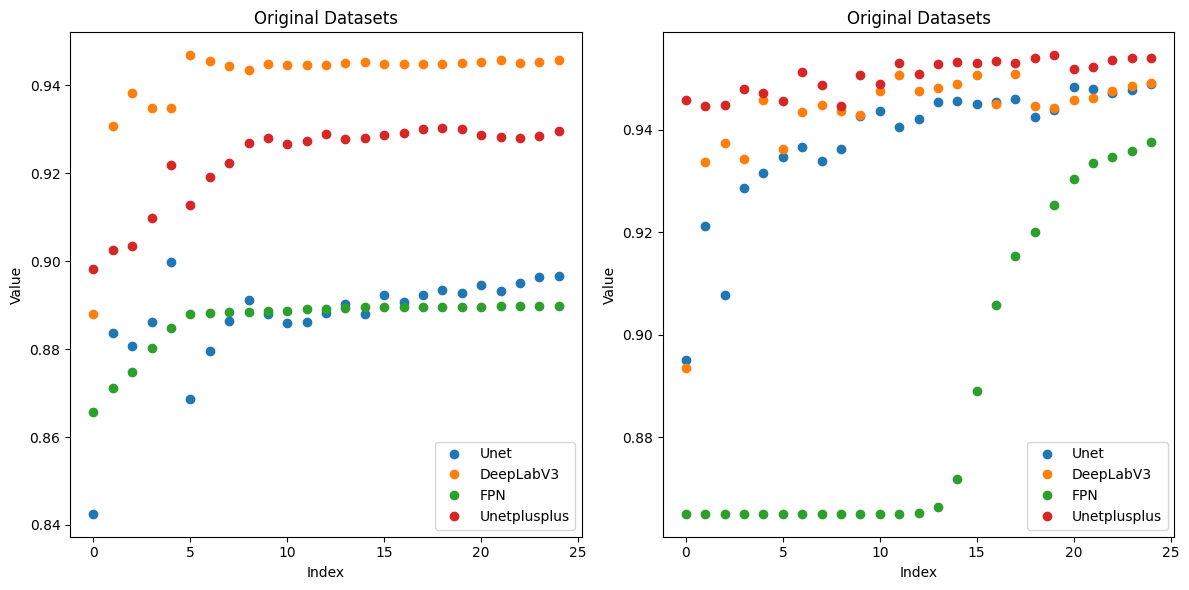

In [116]:
!pwd
fscore_Unet_old = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_13:54/validation_fscore.npy')
fscore_DeepLabV3_old = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_14:00/validation_fscore.npy')
fscore_FPN_old = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_14:02/validation_fscore.npy')
fscore_Unetplusplus_old = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_14:05/validation_fscore.npy')

fscore_Unet = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_14:59/validation_fscore.npy')
fscore_DeepLabV3 = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_15:05/validation_fscore.npy')
fscore_FPN = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_15:07/validation_fscore.npy')
fscore_Unetplusplus = np.load('/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv/results/training_metrics/03_12_15:11/validation_fscore.npy')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plotting all the datasets on one graph
ax1.plot(fscore_Unet_old[5:], 'o', label='Unet')
ax1.plot(fscore_DeepLabV3_old[5:], 'o', label='DeepLabV3')
ax1.plot(fscore_FPN_old[5:], 'o', label='FPN')
ax1.plot(fscore_Unetplusplus_old[5:], 'o', label='Unetplusplus')

ax1.set_title('Original Datasets')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.legend()


ax2.plot(fscore_Unet[5:], 'o', label='Unet')
ax2.plot(fscore_DeepLabV3[5:], 'o', label='DeepLabV3')
ax2.plot(fscore_FPN[5:], 'o', label='FPN')
ax2.plot(fscore_Unetplusplus[5:], 'o', label='Unetplusplus')

ax2.set_title('Original Datasets')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

# IV) Submission

---



In [132]:
MODEL_NAME = "UnetPlusPlus"
# Modify according to model saved that you want to import
MODEL_PATH = model_weights_folder + f'best_model_{MODEL_NAME}.pth'
DEVICE ='cuda'
test_model = torch.load(MODEL_PATH)


In [133]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

### Visualization of results

In [134]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
activate_threshold = True
img_nbr = 10
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_cpu = pr_gt.cpu().numpy().squeeze()
            if activate_threshold:
              pr_gt_cpu[pr_gt_cpu >= foreground_threshold] = 1
              pr_gt_cpu[pr_gt_cpu < foreground_threshold] = 0
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


Output hidden; open in https://colab.research.google.com to view.

## Submission creation

In [135]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)

# Parameters for saving images
output_folder = submission_folder + 'predicted_masks/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    # print("Processing image:", i)
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'
        prediction_pil_resized.save(os.path.join(output_folder, filename))



In [136]:
submission_filename = submission_folder + '{}.csv'.format(MODEL_NAME)
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = output_folder + 'pr_img_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)
